In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import Adam

import keras_tuner as kt
import matplotlib.pyplot as plt
# Modelo
# Cargar dataset
df = pd.read_csv('../datasetintermedio.csv')

# Separar X e y
y = df['Precio_usd']
X = df.drop(columns=['Precio_usd'])

# Escalar con MinMax
scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X)

# Split
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

/Users/matiaslein/Library/Python/3.9/lib/python/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(


In [2]:
def build_model(hp):
    model = Sequential()
    model.add(Dense(units=hp.Int('units_1', 32, 256, step=32),
                    activation='relu', input_shape=(X_train.shape[1],)))
    model.add(Dense(units=hp.Int('units_2', 16, 128, step=16),
                    activation='relu'))
    model.add(Dense(1, activation='linear'))  # Regresión

    model.compile(optimizer=Adam(learning_rate=hp.Choice('lr', [1e-2, 1e-3, 1e-4])),
                  loss='mae',
                  metrics=['mae'])
    return model

# Buscar mejores hiperparámetros
tuner = kt.RandomSearch(
    build_model,
    objective='val_mae',
    max_trials=10,
    executions_per_trial=1,
    overwrite=True,
    directory=None,
    project_name='auto_price_mlp'
)

tuner.search(X_train, y_train, validation_split=0.2, epochs=50, batch_size=32, verbose=0)
best_model = tuner.get_best_models(num_models=1)[0]

/Users/matiaslein/Library/Python/3.9/lib/python/site-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/Users/matiaslein/Library/Python/3.9/lib/python/site-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/Users/matiaslein/Library/Python/3.9/lib/python/site-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__i

In [3]:
history = best_model.fit(X_train, y_train, validation_split=0.2, epochs=100, batch_size=32, verbose=1)

Epoch 1/100


366/366 ━━━━━━━━━━━━━━━━━━━━ 1s 864us/step - loss: 3847.4348 - mae: 3847.4348 - val_loss: 4222.2285 - val_mae: 4222.2285
Epoch 2/100
366/366 ━━━━━━━━━━━━━━━━━━━━ 0s 764us/step - loss: 3794.6072 - mae: 3794.6072 - val_loss: 4304.1909 - val_mae: 4304.1909
Epoch 3/100
366/366 ━━━━━━━━━━━━━━━━━━━━ 0s 589us/step - loss: 3973.1558 - mae: 3973.1558 - val_loss: 4213.7773 - val_mae: 4213.7773
Epoch 4/100
366/366 ━━━━━━━━━━━━━━━━━━━━ 0s 735us/step - loss: 3781.7297 - mae: 3781.7297 - val_loss: 4219.1392 - val_mae: 4219.1392
Epoch 5/100
366/366 ━━━━━━━━━━━━━━━━━━━━ 0s 639us/step - loss: 3799.8406 - mae: 3799.8406 - val_loss: 4172.2354 - val_mae: 4172.2354
Epoch 6/100
366/366 ━━━━━━━━━━━━━━━━━━━━ 0s 542us/step - loss: 3747.9102 - mae: 3747.9102 - val_loss: 4173.7910 - val_mae: 4173.7910
Epoch 7/100
366/366 ━━━━━━━━━━━━━━━━━━━━ 0s 541us/step - loss: 3739.3860 - mae: 3739.3860 - val_loss: 4226.7725 - val_mae: 4226.7725
Epoch 8/100
366/366 ━━━━━━━━━━━━━━━━━━━━ 0s 703us/step - loss: 3740.7632 - mae: 3

In [4]:
y_pred = best_model.predict(X_test).flatten()

mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)
mape = np.mean(np.abs((y_test - y_pred) / y_test)) * 100

print(f"\n--- MÉTRICAS ---")
print(f"MAE: ${mae:,.0f}")
print(f"RMSE: ${rmse:,.0f}")
print(f"R2: {r2:.3f}")
print(f"MAPE: {mape:.2f}%")

115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 354us/step

--- MÉTRICAS ---
MAE: $4,512
RMSE: $34,549
R2: -1.695
MAPE: 51.95%


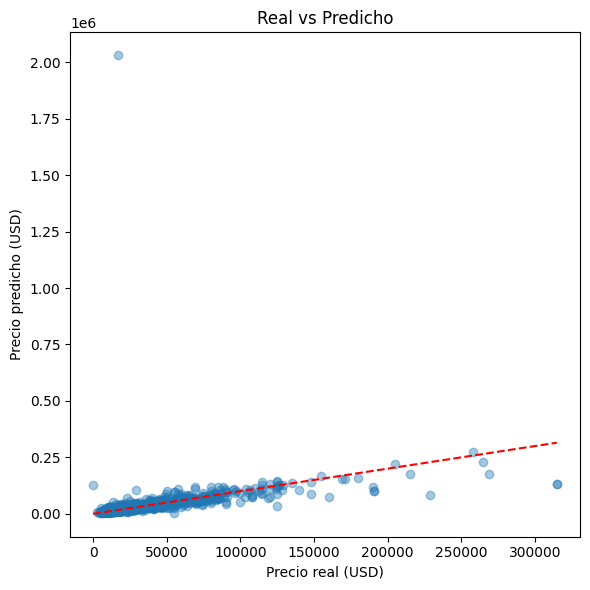

In [5]:
plt.figure(figsize=(6, 6))
plt.scatter(y_test, y_pred, alpha=0.4)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], '--', color='red')
plt.xlabel("Precio real (USD)")
plt.ylabel("Precio predicho (USD)")
plt.title("Real vs Predicho")
plt.tight_layout()
plt.show()